**ON/OFF-Body Detection and Mask Generation**

In [12]:
import os
import numpy as np
import pandas as pd
from itertools import groupby

# ============================================================
# Common helper functions
# ============================================================

def load_sensor_csv(path, n_cols=1):
    # Load E4-style CSV: start time, sampling rate, then values
    data = pd.read_csv(path, header=None, na_values=["NA", "", "NaN", "nan"])
    start_time = float(data.iloc[0, 0])
    freq = float(data.iloc[1, 0])
    values = data.iloc[2:, :n_cols].astype(float).values
    return start_time, freq, values


def load_all_parts(sensor_dir, n_cols=1):
    # Load and concatenate all partXX.csv files of a sensor
    parts = sorted([f for f in os.listdir(sensor_dir) if f.startswith("part") and f.endswith(".csv")])
    all_values, all_timestamps = [], []

    for part in parts:
        try:
            t0, freq, vals = load_sensor_csv(os.path.join(sensor_dir, part), n_cols=n_cols)
            timestamps = t0 + np.arange(len(vals)) / freq
            all_timestamps.append(timestamps)
            all_values.append(vals)
        except Exception as e:
            print(f"Error reading {part} in {sensor_dir}: {e}")

    if not all_values:
        raise ValueError(f"No valid parts found in {sensor_dir}")

    all_values = np.vstack(all_values)
    all_timestamps = np.concatenate(all_timestamps)
    return all_timestamps, freq, all_values


# ============================================================
# Generic ON/OFF-body detection
# ============================================================

def detectar_onbody(eda, temp, acc, freq, t0,
                    eda_min, temp_min, temp_drop, acc_var_min,
                    offbody_min_duration_sec=300,
                    onbody_min_duration_sec=120,
                    include_flat_eda=False):
    # Work at 1-second resolution
    samples_per_sec = int(freq)
    n_secs = min(len(eda), len(temp), len(acc)) // samples_per_sec

    eda = eda[:n_secs * samples_per_sec].reshape((n_secs, samples_per_sec))
    temp = temp[:n_secs * samples_per_sec].reshape((n_secs, samples_per_sec))
    acc = acc[:n_secs * samples_per_sec].reshape((n_secs, samples_per_sec, 3))

    # Per-second features
    eda_mean = np.nanmean(eda, axis=1)
    temp_mean = np.nanmean(temp, axis=1)
    acc_var = np.var(acc, axis=(1, 2))

    # Detect long NaN segments in EDA
    eda_nan = np.isnan(eda_mean)
    nan_blocks = []
    start = None
    for i, v in enumerate(eda_nan):
        if v and start is None:
            start = i
        elif not v and start is not None:
            if i - start >= 60:
                nan_blocks.extend(range(start, i))
            start = None
    if start is not None and (n_secs - start) >= 60:
        nan_blocks.extend(range(start, n_secs))

    eda_nan_mask = np.zeros(n_secs, dtype=bool)
    eda_nan_mask[nan_blocks] = True

    # Temperature drop detection
    temp_series = pd.Series(temp_mean)
    rolling_mean = temp_series.rolling(window=300, min_periods=30).mean()
    temp_drop_mask = (rolling_mean - temp_series) > temp_drop

    # Off-body conditions
    temp_off = (temp_mean < temp_min) | temp_drop_mask
    eda_off = (eda_mean < eda_min) | eda_nan_mask
    acc_still = acc_var < acc_var_min

    # Optional flat EDA detection
    if include_flat_eda:
        eda_std = pd.Series(eda_mean).rolling(window=120, min_periods=30).std()
        eda_flat = eda_std < 0.002
        eda_off = eda_off | eda_flat

    # Combine criteria
    mask_invalid = (temp_off & eda_off) | ((temp_off | eda_off) & acc_still)
    mask = (~mask_invalid).astype(int)

    # Enforce minimum durations
    cleaned = []
    for val, group in groupby(mask):
        g = list(group)
        if val == 0 and len(g) < offbody_min_duration_sec:
            cleaned.extend([1] * len(g))
        elif val == 1 and len(g) < onbody_min_duration_sec:
            cleaned.extend([0] * len(g))
        else:
            cleaned.extend([val] * len(g))

    timestamps = t0 + np.arange(len(cleaned))
    return np.array(cleaned), np.array(timestamps)


# ============================================================
# Individual processing: Embrace
# ============================================================

def procesar_paciente_embrace(patient_id,
                              base_input="~/TFM/2.step2_e4csv",
                              base_output="~/TFM/5.on_off_body/Embrace_mask"):
    base_input = os.path.expanduser(base_input)
    base_output = os.path.expanduser(base_output)

    patient_in = os.path.join(base_input, patient_id)
    eda_dir = os.path.join(patient_in, "EDA_filtrado")
    temp_dir = os.path.join(patient_in, "TEMP")
    acc_dir = os.path.join(patient_in, "ACC_filtrado")
    out_dir = os.path.join(base_output, patient_id)
    os.makedirs(out_dir, exist_ok=True)

    print(f"Processing {patient_id} (Embrace Plus, adaptive thresholds)")

    # Load signals
    eda_ts, eda_freq, eda_vals = load_all_parts(eda_dir, n_cols=1)
    temp_ts, _, temp_vals = load_all_parts(temp_dir, n_cols=1)
    acc_ts, _, acc_vals = load_all_parts(acc_dir, n_cols=3)

    # Align lengths
    n = min(len(eda_vals), len(temp_vals), len(acc_vals))
    eda_vals, temp_vals, acc_vals = eda_vals[:n], temp_vals[:n], acc_vals[:n]
    t0 = max(eda_ts[0], temp_ts[0], acc_ts[0])

    # Dynamic thresholds
    temp_mean = np.nanmean(temp_vals)
    temp_std = np.nanstd(temp_vals)
    eda_mean = np.nanmean(eda_vals)
    eda_std = np.nanstd(eda_vals)

    temp_min = max(temp_mean - 2.0 * temp_std, 27.0)
    temp_drop = max(1.0, 1.2 * temp_std)
    eda_min = max(0.02, eda_mean * 0.05)
    acc_var_min = 0.015

    # ON/OFF-body detection
    mask, timestamps = detectar_onbody(
        eda_vals.flatten(),
        temp_vals.flatten(),
        acc_vals.reshape(-1, 3),
        eda_freq,
        t0,
        eda_min=eda_min,
        temp_min=temp_min,
        temp_drop=temp_drop,
        acc_var_min=acc_var_min,
        offbody_min_duration_sec=180,
        onbody_min_duration_sec=90,
        include_flat_eda=True
    )

    # Save mask
    df_mask = pd.DataFrame({"timestamp": timestamps, "is_onbody": mask})
    df_mask.to_csv(os.path.join(out_dir, "onbody_mask.csv"), index=False)

    # Save parameters
    df_params = pd.DataFrame([{
        "patient_id": patient_id,
        "temp_mean": temp_mean,
        "temp_std": temp_std,
        "eda_mean": eda_mean,
        "eda_std": eda_std,
        "temp_min": temp_min,
        "temp_drop": temp_drop,
        "eda_min": eda_min,
        "acc_var_min": acc_var_min
    }])
    df_params.to_csv(os.path.join(out_dir, "onbody_params.csv"), index=False)

    print(f"Embrace mask saved ({len(df_mask)} samples)")
    return len(df_mask), np.sum(mask), np.sum(mask == 0)


# ============================================================
# Individual processing: Empatica
# ============================================================

def procesar_paciente_empatica(patient_id,
                               base_input="~/TFM/EMPATICA_all",
                               base_output="~/TFM/5.on_off_body/Empatica_mask"):
    base_input = os.path.expanduser(base_input)
    base_output = os.path.expanduser(base_output)

    patient_in = os.path.join(base_input, patient_id)
    out_dir = os.path.join(base_output, patient_id)
    os.makedirs(out_dir, exist_ok=True)

    print(f"Processing {patient_id} (Empatica E4)")

    eda_path = os.path.join(patient_in, "EDA.csv")
    temp_path = os.path.join(patient_in, "TEMP.csv")
    acc_path = os.path.join(patient_in, "ACC.csv")

    eda_t0, eda_freq, eda_vals = load_sensor_csv(eda_path, n_cols=1)
    _, _, temp_vals = load_sensor_csv(temp_path, n_cols=1)
    _, _, acc_vals = load_sensor_csv(acc_path, n_cols=3)

    n = min(len(eda_vals), len(temp_vals), len(acc_vals))
    eda_vals, temp_vals, acc_vals = eda_vals[:n], temp_vals[:n], acc_vals[:n]

    mask, timestamps = detectar_onbody(
        eda_vals.flatten(),
        temp_vals.flatten(),
        acc_vals.reshape(-1, 3),
        eda_freq,
        eda_t0,
        eda_min=0.05,
        temp_min=25.0,
        temp_drop=2.0,
        acc_var_min=0.02
    )

    df = pd.DataFrame({"timestamp": timestamps, "is_onbody": mask})
    df.to_csv(os.path.join(out_dir, "onbody_mask.csv"), index=False)

    print(f"Empatica mask saved ({len(df)} samples)")
    return len(df), np.sum(mask), np.sum(mask == 0)


# ============================================================
# Global automation
# ============================================================

def procesar_todos(emap):
    resumen = []

    for embrace_id, empatica_id in emap.items():
        try:
            total_e, on_e, _ = procesar_paciente_embrace(embrace_id)
            total_m, on_m, _ = procesar_paciente_empatica(empatica_id)
            resumen.append({
                "embrace_id": embrace_id,
                "empatica_id": empatica_id,
                "embrace_on_pct": round(100 * on_e / total_e, 2),
                "empatica_on_pct": round(100 * on_m / total_m, 2),
            })
        except Exception as e:
            print(f"Error processing {embrace_id}/{empatica_id}: {e}")

    df = pd.DataFrame(resumen)
    out_path = os.path.expanduser("~/TFM/5.on_off_body/summary_onoff.csv")
    df.to_csv(out_path, index=False)
    print("Global summary saved at:", out_path)
    print(df)


# ============================================================
# Main
# ============================================================

if __name__ == "__main__":
    emp_emp_map = {
        "CLIDEM01": "1823370",
        "CLIDEM010": "1842113",
        "CLIDEM011": "1891004",
        "CLIDEM02": "1832743",
        "CLIDEM030": "1916330",
        "CLIDEM031": "1920720",
        "CLIDEM04": "1833368",
        "CLIDEM05": "1837341",
        "CLIDEM06": "1840660",
        "CLIDEM07": "1840605",
        "CLIDEM08": "1841430",
        "CLIDEM09": "1842162",
        "CLIDEM11": "1891004",
        "CLIDEM12": "1891236",
        "CLIDEM13": "1895868",
        "CLIDEM14": "1891785",
        "CLIDEM15": "1894131",
        "CLIDEM16": "1895849",
        "CLIDEM17": "1896649",
        "CLIDEM18": "1898066",
        "CLIDEM19": "1900189",
        "CLIDEM20": "1906938",
        "CLIDEM21": "1907236",
        "CLIDEM22": "1908525",
        "CLIDEM23": "1909384",
        "CLIDEM24": "1910353",
        "CLIDEM25": "1911867",
        "CLIDEM26": "1912600",
        "CLIDEM27": "1913365",
        "CLIDEM29": "1914654"
    }

    procesar_todos(emp_emp_map)

🔍 Procesando CLIDEM01 (Embrace Plus calibrado dinámicamente)
✅ Guardado Embrace mask (197807 filas)
🔍 Procesando 1823370 (Empatica E4)
✅ Guardado Empatica mask (73776 filas)
🔍 Procesando CLIDEM010 (Embrace Plus calibrado dinámicamente)
✅ Guardado Embrace mask (184005 filas)
🔍 Procesando 1842113 (Empatica E4)
✅ Guardado Empatica mask (165981 filas)
🔍 Procesando CLIDEM011 (Embrace Plus calibrado dinámicamente)
✅ Guardado Embrace mask (165888 filas)
🔍 Procesando 1891004 (Empatica E4)
✅ Guardado Empatica mask (169905 filas)
🔍 Procesando CLIDEM02 (Embrace Plus calibrado dinámicamente)
✅ Guardado Embrace mask (289157 filas)
🔍 Procesando 1832743 (Empatica E4)
✅ Guardado Empatica mask (170524 filas)
🔍 Procesando CLIDEM030 (Embrace Plus calibrado dinámicamente)
✅ Guardado Embrace mask (207119 filas)
🔍 Procesando 1916330 (Empatica E4)
✅ Guardado Empatica mask (124002 filas)
🔍 Procesando CLIDEM031 (Embrace Plus calibrado dinámicamente)
✅ Guardado Embrace mask (64997 filas)
🔍 Procesando 1920720 (E

**Comparative Visualization of Physiological Signals with On/Off-Body Detection**

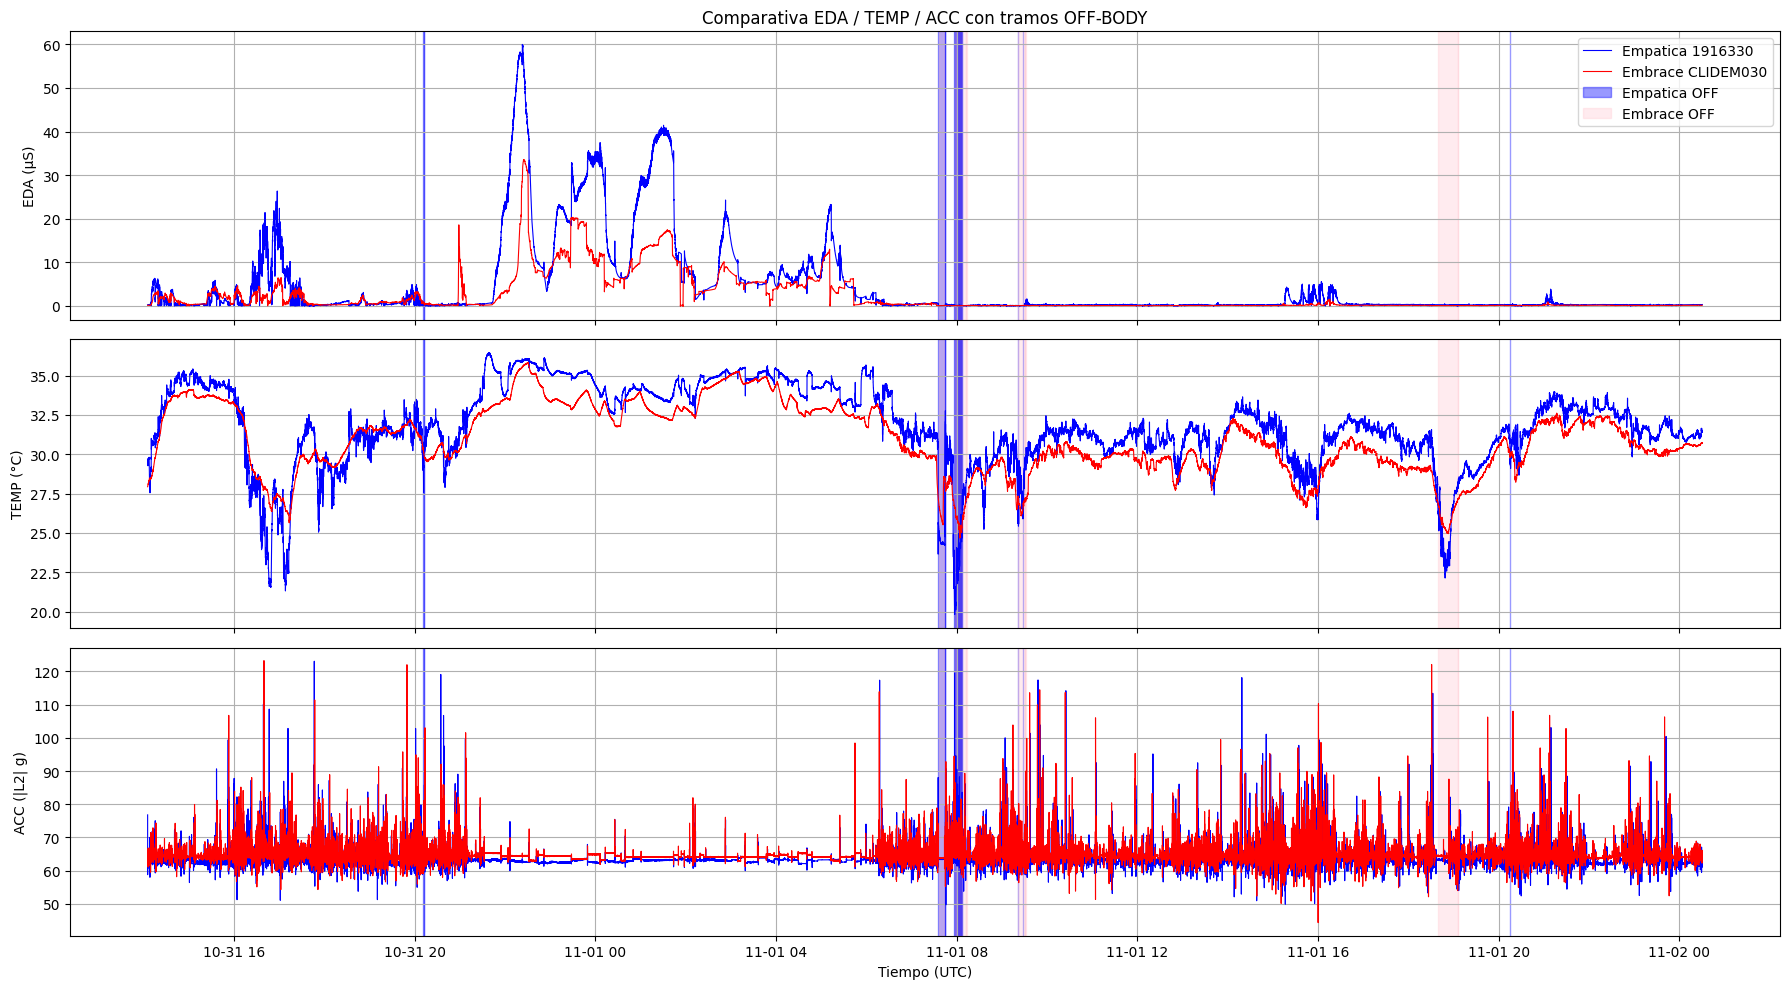

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# Helper functions for reading sensor files
# ------------------------------------------------------------

def read_signal_file(path, n_cols=1):
    """
    Read a sensor CSV file (Empatica or Embrace format).
    Returns a DataFrame with timestamps and values.
    """
    d = pd.read_csv(path, header=None, na_values=["NA", "NaN", ""])
    t0 = float(d.iloc[0, 0])          # start timestamp (epoch seconds)
    freq = float(d.iloc[1, 0])        # sampling frequency
    vals = d.iloc[2:, :n_cols].apply(pd.to_numeric, errors="coerce").dropna().values

    # Ensure correct shape for single-column signals
    if n_cols == 1:
        vals = vals.flatten()

    ts = t0 + np.arange(len(vals)) / freq
    return pd.DataFrame({
        "time": pd.to_datetime(ts, unit="s", utc=True),
        "vals": list(vals)
    })


def read_acc_file(path):
    """
    Read ACC file and compute vector magnitude (L2 norm).
    """
    df = read_signal_file(path, n_cols=3)
    vals = np.vstack(df["vals"].to_numpy())
    mag = np.linalg.norm(vals, axis=1)
    return pd.DataFrame({"time": df["time"], "ACC": mag})


def read_mask(path):
    """
    Read ON/OFF-body mask file.
    """
    df = pd.read_csv(path)
    df["time"] = pd.to_datetime(df["timestamp"], unit="s", utc=True)
    return df


def downsample(df, colname):
    """
    Downsample signal to 1 Hz using mean aggregation.
    """
    df["sec"] = df["time"].dt.floor("1s")
    return (
        df.groupby("sec", as_index=False)[colname]
        .mean()
        .rename(columns={"sec": "time"})
    )


def get_intervals(df_mask):
    """
    Extract OFF-body intervals (is_onbody == 0).
    Returns a list of (start, end) timestamps.
    """
    df_mask["offbody"] = (df_mask["is_onbody"] == 0).astype(int)
    intervals, start = [], None

    for i in range(1, len(df_mask)):
        prev = df_mask["offbody"].iloc[i - 1]
        curr = df_mask["offbody"].iloc[i]

        if curr == 1 and prev == 0:
            start = df_mask["time"].iloc[i]
        elif curr == 0 and prev == 1 and start is not None:
            end = df_mask["time"].iloc[i]
            intervals.append((start, end))
            start = None

    return intervals


# ------------------------------------------------------------
# Main plotting function
# ------------------------------------------------------------

def plot_compare_all(empatica_id,
                     embrace_id,
                     base_empatica="~/TFM/EMPATICA_all",
                     base_embrace="~/TFM/2.step2_e4csv",
                     base_mask_empatica="~/TFM/5.on_off_body/Empatica_mask",
                     base_mask_embrace="~/TFM/5.on_off_body/Embrace_mask",
                     save_fig=False):
    """
    Plot EDA, TEMP and ACC comparison between Empatica and Embrace,
    including OFF-body intervals.
    """

    # Expand base paths
    base_empatica = os.path.expanduser(base_empatica)
    base_embrace = os.path.expanduser(base_embrace)
    base_mask_empatica = os.path.expanduser(base_mask_empatica)
    base_mask_embrace = os.path.expanduser(base_mask_embrace)

    # Empatica files
    eda_emp_path = os.path.join(base_empatica, empatica_id, "EDA.csv")
    temp_emp_path = os.path.join(base_empatica, empatica_id, "TEMP.csv")
    acc_emp_path = os.path.join(base_empatica, empatica_id, "ACC.csv")
    mask_emp_path = os.path.join(base_mask_empatica, empatica_id, "onbody_mask.csv")

    # Embrace directories
    eda_embr_dir = os.path.join(base_embrace, embrace_id, "EDA_filtrado")
    temp_embr_dir = os.path.join(base_embrace, embrace_id, "TEMP")
    acc_embr_dir = os.path.join(base_embrace, embrace_id, "ACC_filtrado")
    mask_embr_path = os.path.join(base_mask_embrace, embrace_id, "onbody_mask.csv")

    # Read Empatica signals
    df_eda_e = read_signal_file(eda_emp_path, n_cols=1).rename(columns={"vals": "EDA"})
    df_temp_e = read_signal_file(temp_emp_path, n_cols=1).rename(columns={"vals": "TEMP"})
    df_acc_e = read_acc_file(acc_emp_path)
    mask_e = read_mask(mask_emp_path)

    # Helper to concatenate Embrace parts
    def concat_parts(sensor_dir, n_cols):
        parts = sorted([f for f in os.listdir(sensor_dir) if f.lower().startswith("part")])
        dfs = []
        for p in parts:
            dfs.append(read_signal_file(os.path.join(sensor_dir, p), n_cols=n_cols))
        return pd.concat(dfs, ignore_index=True).sort_values("time")

    # Read Embrace signals
    df_eda_m = concat_parts(eda_embr_dir, 1).rename(columns={"vals": "EDA"})
    df_temp_m = concat_parts(temp_embr_dir, 1).rename(columns={"vals": "TEMP"})
    df_acc_m = concat_parts(acc_embr_dir, 3)

    vals = np.vstack(df_acc_m["vals"].to_numpy())
    df_acc_m["ACC"] = np.linalg.norm(vals, axis=1)
    df_acc_m = df_acc_m[["time", "ACC"]]
    mask_m = read_mask(mask_embr_path)

    # Compute common temporal window
    t_min = max(
        df_eda_e["time"].min(), df_temp_e["time"].min(), df_acc_e["time"].min(),
        df_eda_m["time"].min(), df_temp_m["time"].min(), df_acc_m["time"].min(),
        mask_e["time"].min(), mask_m["time"].min()
    )
    t_max = min(
        df_eda_e["time"].max(), df_temp_e["time"].max(), df_acc_e["time"].max(),
        df_eda_m["time"].max(), df_temp_m["time"].max(), df_acc_m["time"].max(),
        mask_e["time"].max(), mask_m["time"].max()
    )

    def trim(df):
        return df[(df["time"] >= t_min) & (df["time"] <= t_max)]

    df_eda_e, df_temp_e, df_acc_e = map(trim, [df_eda_e, df_temp_e, df_acc_e])
    df_eda_m, df_temp_m, df_acc_m = map(trim, [df_eda_m, df_temp_m, df_acc_m])
    mask_e, mask_m = map(trim, [mask_e, mask_m])

    # Downsample all signals to 1 Hz
    df_eda_e = downsample(df_eda_e, "EDA")
    df_temp_e = downsample(df_temp_e, "TEMP")
    df_acc_e = downsample(df_acc_e, "ACC")

    df_eda_m = downsample(df_eda_m, "EDA")
    df_temp_m = downsample(df_temp_m, "TEMP")
    df_acc_m = downsample(df_acc_m, "ACC")

    # Extract OFF-body intervals
    off_e = get_intervals(mask_e)
    off_m = get_intervals(mask_m)

    # Plot signals
    fig, axs = plt.subplots(3, 1, figsize=(18, 10), sharex=True)

    # EDA
    axs[0].plot(df_eda_e["time"], df_eda_e["EDA"], color="blue", linewidth=0.8, label=f"Empatica {empatica_id}")
    axs[0].plot(df_eda_m["time"], df_eda_m["EDA"], color="red", linewidth=0.8, label=f"Embrace {embrace_id}")
    axs[0].set_ylabel("EDA (µS)")
    axs[0].set_title("EDA / TEMP / ACC comparison with OFF-body intervals")

    # TEMP
    axs[1].plot(df_temp_e["time"], df_temp_e["TEMP"], color="blue", linewidth=0.8)
    axs[1].plot(df_temp_m["time"], df_temp_m["TEMP"], color="red", linewidth=0.8)
    axs[1].set_ylabel("TEMP (°C)")

    # ACC
    axs[2].plot(df_acc_e["time"], df_acc_e["ACC"], color="blue", linewidth=0.8)
    axs[2].plot(df_acc_m["time"], df_acc_m["ACC"], color="red", linewidth=0.8)
    axs[2].set_ylabel("ACC (|L2|)")
    axs[2].set_xlabel("Time (UTC)")

    # Shade OFF-body intervals
    for ax in axs:
        for s, e in off_e:
            ax.axvspan(s, e, color="blue", alpha=0.4)
        for s, e in off_m:
            ax.axvspan(s, e, color="pink", alpha=0.3)
        ax.grid(True)

    axs[0].legend(loc="upper right")
    plt.tight_layout()

    if save_fig:
        out_path = os.path.expanduser(
            f"~/TFM/5.on_off_body_empatica/compare_ALL_{empatica_id}_{embrace_id}.png"
        )
        plt.savefig(out_path, dpi=150)
    else:
        plt.show()


# ------------------------------------------------------------
# Example execution
# ------------------------------------------------------------

if __name__ == "__main__":
    plot_compare_all(empatica_id="1916330", embrace_id="CLIDEM030")